In [37]:
!pip install pandas matplotlib seaborn scikit-learn xgboost --quiet

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

In [39]:
url = "/content/drive/MyDrive/Fraud.csv"
df = pd.read_csv(url)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [40]:
print(df['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


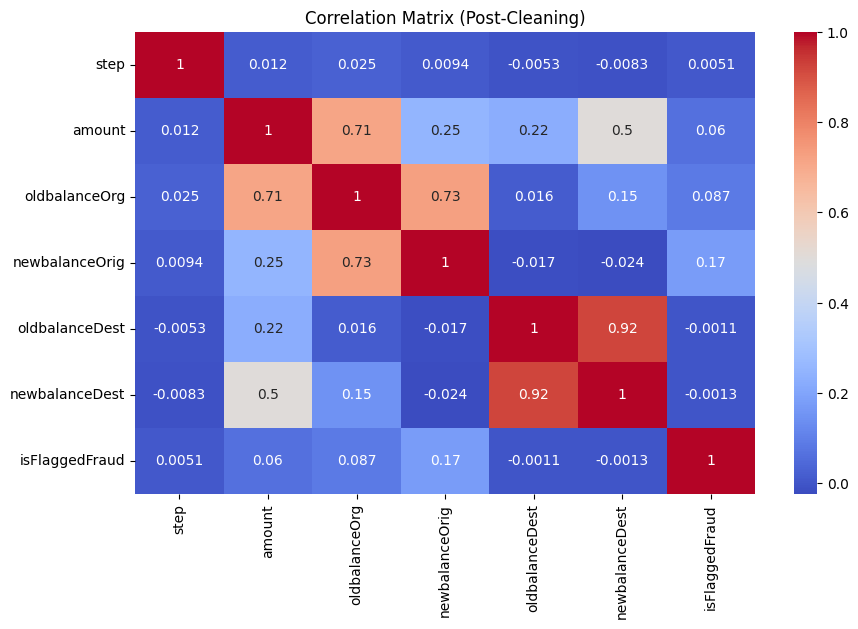

In [45]:
# Data Cleaning
from sklearn.preprocessing import LabelEncoder

fraud_col = 'isFraud'
assert fraud_col in df.columns, "Target column for fraud not found!"

# Handle Missing Values
# Split into fraud and non-fraud before cleaning
fraud_df = df[df[fraud_col] == 1].copy()
nonfraud_df = df[df[fraud_col] == 0].copy()

# Only clean non-fraud data
nonfraud_df.dropna(inplace=True)

# Encode Categorical Columns
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    # Fit on full data to keep consistency
    le.fit(df[col].astype(str))
    fraud_df[col] = le.transform(fraud_df[col].astype(str))
    nonfraud_df[col] = le.transform(nonfraud_df[col].astype(str))

# Remove Outliers (only from non-fraud)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

numeric_cols = df.select_dtypes(include=np.number).columns.drop(fraud_col)
for col in numeric_cols:
    nonfraud_df = remove_outliers_iqr(nonfraud_df, col)

# Combine Data Back
df_cleaned = pd.concat([fraud_df, nonfraud_df], axis=0).sample(frac=1).reset_index(drop=True)

# Correlation Heatmap (on cleaned data)
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Post-Cleaning)")
plt.show()


In [46]:
print(df['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_cleaned.drop('isFraud', axis=1)
y = df_cleaned['isFraud']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

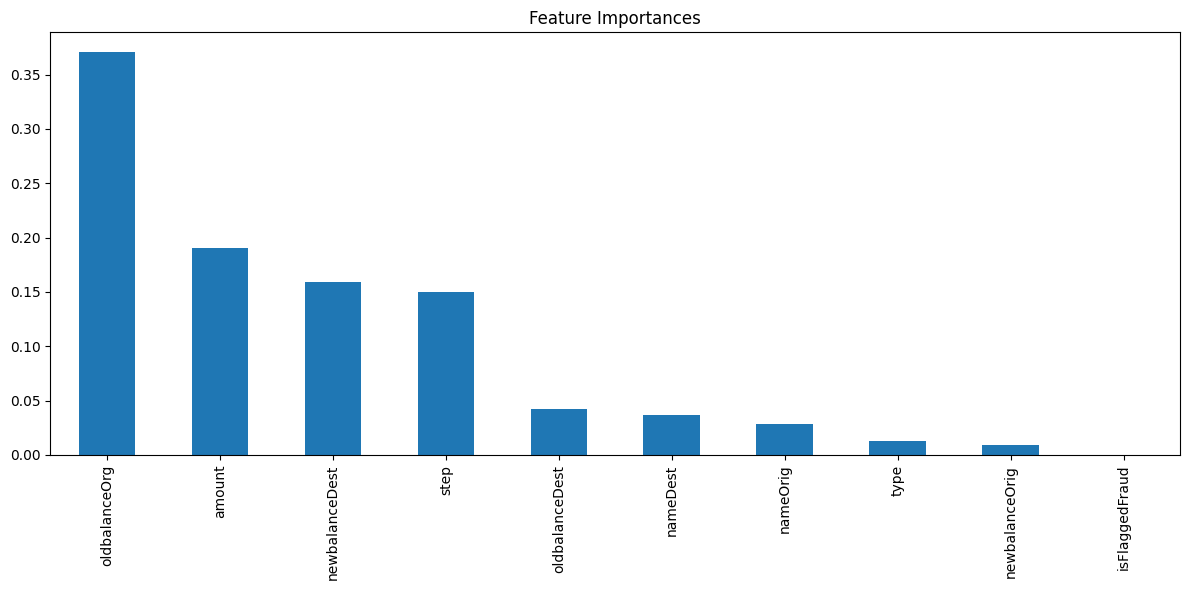

In [48]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Take a smaller sample (e.g., 50,000 rows only) for feature importance
sample_X = X.sample(n=50000, random_state=42)
sample_y = y.loc[sample_X.index]

# Train on sample
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(sample_X, sample_y)

# Plot Feature Importances
importances = pd.Series(rf.feature_importances_, index=sample_X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6), title='Feature Importances')
plt.tight_layout()
plt.show()

In [49]:
# Encoding categorical columns
from sklearn.preprocessing import LabelEncoder

for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [50]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:\n", y_train_bal.value_counts())

After SMOTE:
 isFraud
0    4448085
1    4448085
Name: count, dtype: int64


In [51]:
import xgboost as xgb

model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[1902412    3910]
 [     43    2421]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.38      0.98      0.55      2464

    accuracy                           1.00   1908786
   macro avg       0.69      0.99      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9988858959231374


In [53]:
# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Spliting the data
from sklearn.model_selection import train_test_split
X = df.drop(columns=['isFraud'])
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Balancing the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Training XGBoost
import xgboost as xgb
model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train_bal, y_train_bal)

# Prediction and Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[1902412    3910]
 [     43    2421]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.38      0.98      0.55      2464

    accuracy                           1.00   1908786
   macro avg       0.69      0.99      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786


ROC-AUC Score: 0.9988858959231374


In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_bal).value_counts())

Class distribution after SMOTE:
isFraud
0    4448085
1    4448085
Name: count, dtype: int64


In [55]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[1902412    3910]
 [     43    2421]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.38      0.98      0.55      2464

    accuracy                           1.00   1908786
   macro avg       0.69      0.99      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786


ROC-AUC Score: 0.9988858959231374


Top Fraud Predictors:
 newbalanceOrig    0.802636
oldbalanceOrg     0.102082
nameDest          0.038811
amount            0.037877
type              0.005309
dtype: float32


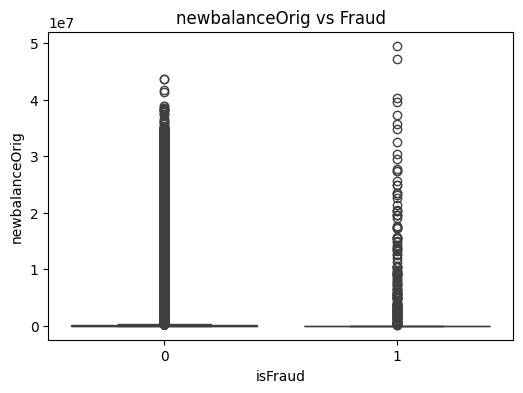

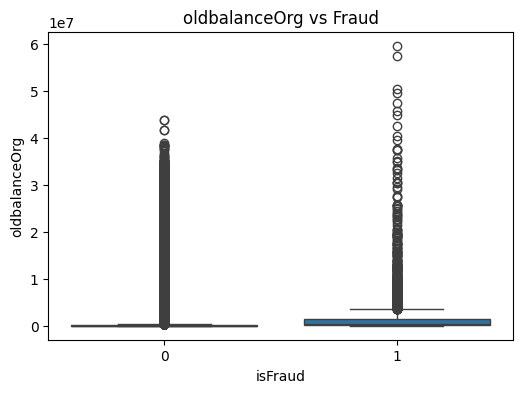

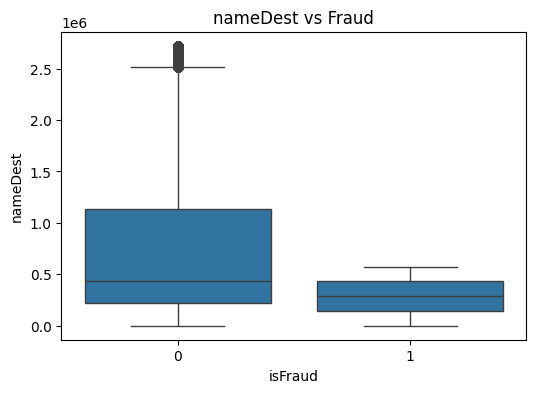

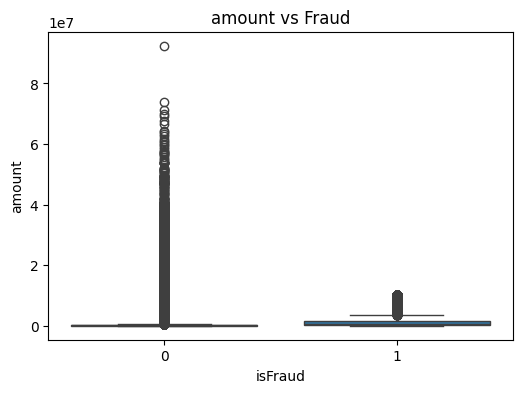

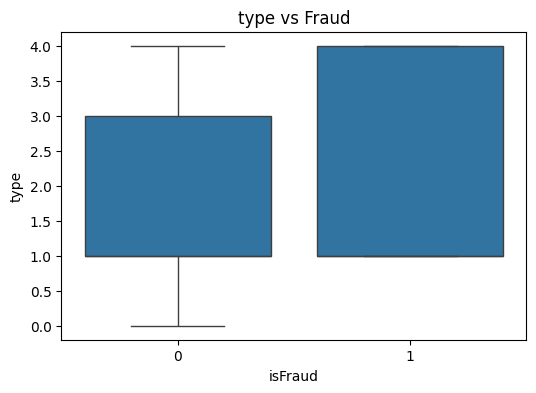

In [56]:
#Step 6: Interpret Key Predictors

feat_importance = pd.Series(model.feature_importances_, index=X.columns)
top_feats = feat_importance.sort_values(ascending=False).head(5)
print("Top Fraud Predictors:\n", top_feats)

for feat in top_feats.index:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=y, y=df[feat])
    plt.title(f'{feat} vs Fraud')
    plt.show()

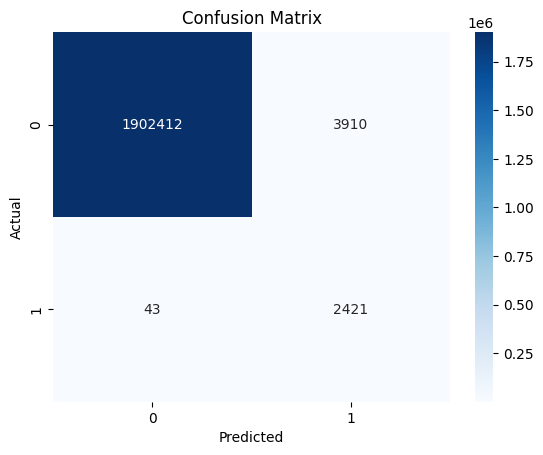

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.38      0.98      0.55      2464

    accuracy                           1.00   1908786
   macro avg       0.69      0.99      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC AUC Score: 0.9988858959231374


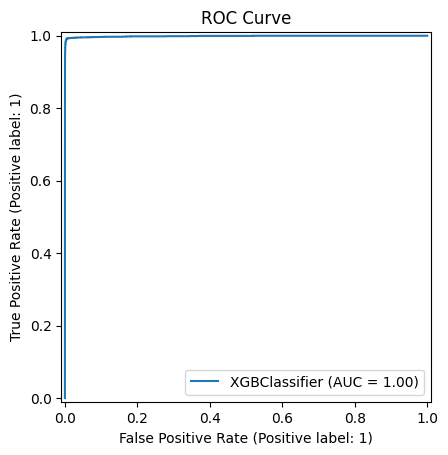

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


In [58]:
print("""Prevention Measures:
1. Implement real-time fraud detection alerts.
2. Introduce stricter transaction verification for flagged behaviors.
3. Monitor top features like transaction amount, frequency, location mismatch.
4. Educate customers on phishing and social engineering.
5. Use anomaly detection tools along with traditional ML models.
""")


Prevention Measures:
1. Implement real-time fraud detection alerts.
2. Introduce stricter transaction verification for flagged behaviors.
3. Monitor top features like transaction amount, frequency, location mismatch.
4. Educate customers on phishing and social engineering.
5. Use anomaly detection tools along with traditional ML models.



In [59]:
print("""
Effectiveness Check:
- A/B test fraud prevention tools (one group with system, one without)
- Monitor drop in fraud rate over weeks/months
- Track false positives and false negatives
- Regularly retrain the model on new data
""")


Effectiveness Check:
- A/B test fraud prevention tools (one group with system, one without)
- Monitor drop in fraud rate over weeks/months
- Track false positives and false negatives
- Regularly retrain the model on new data

